<a href="https://colab.research.google.com/gist/Lihi-Gur-Arie/427ecce6a5c7f279d06f3910941e0145/florence2_inference_by_lihi_gur_arie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

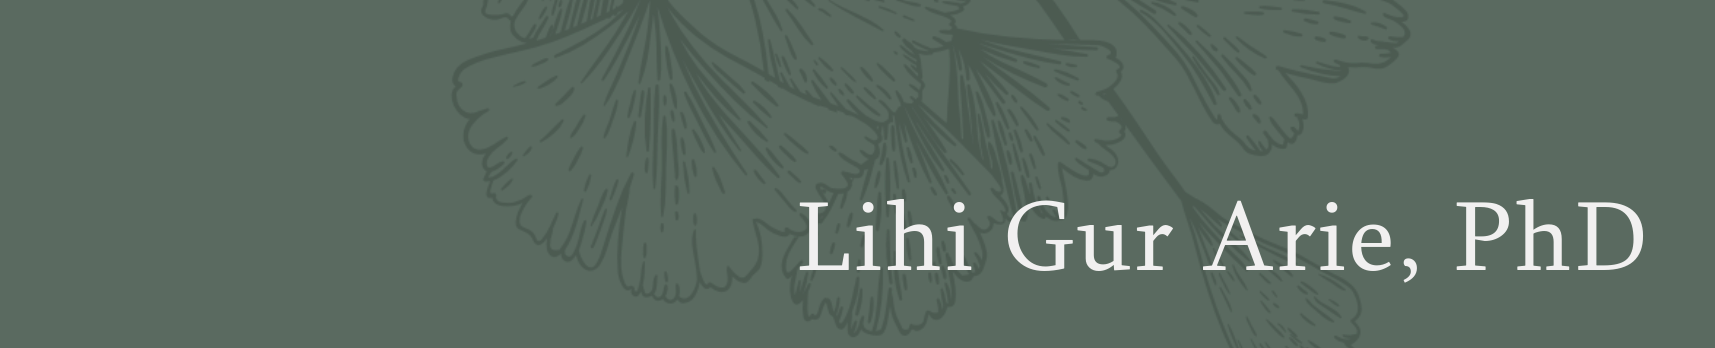

# <font color=40534C size="6.5">**Florence-2: Advancing Multiple Vision Tasks with a Single VLM Model**</font>

<font color=40534C>This notebook is part of the **"Florence-2: Mastering Multiple Vision Tasks with a Single VLM Model"**  tutorial by  **Dr. Lihi Gur Arie**.
For the full tutorial please visit [here](https://medium.com/@lihigurarie/435d251976d0?source=friends_link&sk=e25bdee736a9aa9ace1ca80b98a036a4)<font>

###<font color=40534C>**Hugging Face Setup**</font>

<font color=40534C>**1. Hugging Face Account**: If you don't already have one, you can create a free Hugging Face account by clicking [here](https://huggingface.co/join).

<font color=40534C>**2. Hugging Face Token**: Generate a Hugging Face access (preferably write permission) token by clicking [here](https://huggingface.co/settings/tokens)

<font color=40534C>**3. Configure your HF token**: Add your Hugging Face token to the Colab Secrets manager:

<font color=40534C>Create a new secret with the name HF_TOKEN, paste your token key into the Value input box of HF_TOKEN (🔑), and Toggle the Notebook access on.

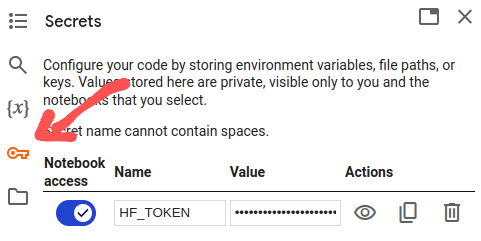

###<font color=40534C>**Install & Import Requirements**</font>

In [ ]:
!pip install -q einops timm flash_attn
!pip install -q jupyter_bbox_widget

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import requests
import copy
import torch
import base64
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# When using Colab:
from google.colab import output
output.enable_custom_widget_manager()
from jupyter_bbox_widget import BBoxWidget

%matplotlib inline

###<font color=40534C>**Load Model**</font>

<font color=40534C>Load the Florence-2 model and processor from HuggingFace. Ensure you have access to a GPU for faster inference times.</font>

In [ ]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

###<font color=40534C>**Load image**</font>

--2024-10-09 13:58:00--  https://drive.usercontent.google.com/download?id=12e8HNfafMIqST2rlqYDKNFTvfD66QzPr&export=download&authuser=0
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42326 (41K) [image/jpeg]
Saving to: ‘camera_image.jpeg’

camera_image.jpeg   100%[===================>]  41.33K  --.-KB/s    in 0.003s  

2024-10-09 13:58:02 (16.1 MB/s) - ‘camera_image.jpeg’ saved [42326/42326]



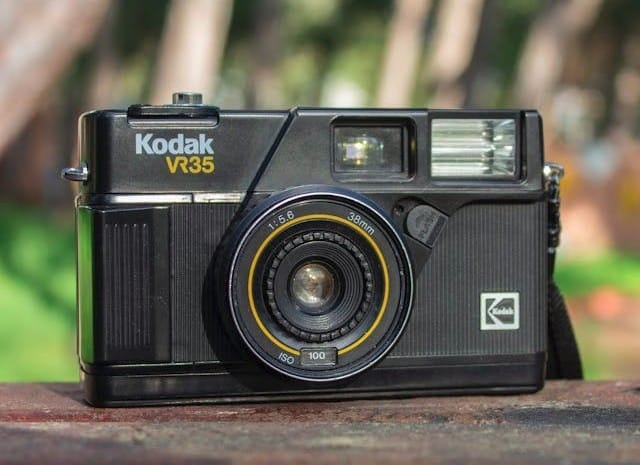

In [ ]:
!wget -O camera_image.jpeg "https://drive.usercontent.google.com/download?id=12e8HNfafMIqST2rlqYDKNFTvfD66QzPr&export=download&authuser=0"
img_path = "/content/camera_image.jpeg"
image = Image.open(img_path)
image

###<font color=40534C>**Auxiliary Functions**


In [ ]:
def run_example(image, task_prompt, text_input='', ):

    prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        do_sample=False,
        num_beams=3,
        early_stopping=False,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer



In [ ]:
def draw_bbox(image, data):

    fig, ax = plt.subplots()
    ax.imshow(image)

    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    ax.axis('off')
    plt.show()



def draw_ocr_bboxes(image, prediction):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        if label.startswith('</s>'):
          label = label[4:]

        color = (238, 130, 238, 128)
        new_box = np.array(box).tolist()
        draw.polygon(new_box, width=3, outline=color)

        draw.text((new_box[0], new_box[1]+30),
                    "{}".format(label),
                    align="right",
                    fill='aqua')
    display(image)




def draw_polygons(image, prediction):

    overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    color = (238, 130, 238, 128)  # violet, semi-transparent
    outline_color = (*color[:3], 255)  # Full opacity for outline

    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        for polygon in polygons:
            polygon = np.array(polygon).flatten().tolist()
            if len(polygon) < 6:  # Less than 3 points
                continue

            draw.polygon(polygon, outline=outline_color, fill=color)
            draw.text((polygon[0] + 8, polygon[1] + 2), label, fill=outline_color)

    return Image.alpha_composite(image.convert('RGBA'), overlay)

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded


def convert_bbox_to_florence2(widget, image_path):
    """Convert widget bbox to Florence-2 format."""
    box = widget.bboxes[0]
    box = np.array([box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']])

    w, h = Image.open(image_path).size
    box = (box / [w, h, w, h] * 1000).astype(int)

    return ''.join(f'<loc_{coord}>' for coord in box)


def convert_to_od_format(data):

    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

#<font color=40534C> **Tasks**
##<font color=40534C>**1. Captioning Generation Related Tasks:**
###<font color=40534C>**1.1 - Generate Captions**

We can generate captions at varying levels of detail using Florence-2. The following examples show how to generate basic, detailed, and more detailed captions for the input image.</font>


In [ ]:
print (run_example(image, task_prompt='<CAPTION>'))

print (run_example(image, task_prompt='<DETAILED_CAPTION>'))

print (run_example(image, task_prompt='<MORE_DETAILED_CAPTION>'))

{'<CAPTION>': 'A black camera sitting on top of a wooden table.'}
{'<DETAILED_CAPTION>': 'The image shows a black Kodak V35 35mm film camera sitting on top of a wooden table with a blurred background.'}
{'<MORE_DETAILED_CAPTION>': 'The image is a close-up of a Kodak VR35 digital camera. The camera is black in color and has the Kodak logo on the top left corner. The body of the camera is made of wood and has a textured grip for easy handling. The lens is in the center of the body and is surrounded by a gold-colored ring. On the top right corner, there is a small LCD screen and a flash. The background is blurred, but it appears to be a wooded area with trees and greenery.'}


###<font color=40534C>**1.2 Generate Caption for a Given Bounding Box**
We can generate captions or categories for specific regions of an image. You can use the widget to manually draw a bounding box on the image. Once you're done drawing the box, click 'Submit' to extract the coordinates, which will be used for generating a caption or category for the selected region.
</font>

In [ ]:
widget = BBoxWidget()
widget.image = encode_image(img_path)
display(widget)

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

<font color=40534C>
After manually drawing the bounding box using the widget, we will convert the bounding box coordinates into the format required by Florence-2, and use it to generate captions or categories for the selected region.
</font>

In [ ]:
box_str = convert_bbox_to_florence2(widget, img_path)

results = run_example(image, task_prompt='<REGION_TO_CATEGORY>', text_input=box_str)
print("Region category:", results)

results = run_example(image, task_prompt= '<REGION_TO_DESCRIPTION>', text_input=box_str)
print("Region description:", results)

Region category: {'<REGION_TO_CATEGORY>': 'camera lens<loc_337><loc_410><loc_656><loc_847>'}
Region description: {'<REGION_TO_DESCRIPTION>': 'camera<loc_337><loc_410><loc_656><loc_847>'}


#<font color=40534C size="5.5">**2. Object Detection**</font>
###<font color=40534C>**2.1 - Generate Bounding Boxes and Text for Objects**</font>

<font color=40534C>Florence-2 can automatically detect densely packed regions in an image and provide the coordinates of their bounding boxes with eighter labels or captions.
</font>   

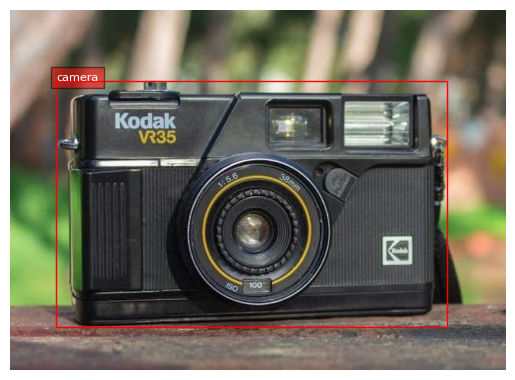

{'<OD>': {'bboxes': [[59.19999694824219, 91.37249755859375, 563.5199584960938, 408.50250244140625]], 'labels': ['camera']}}


In [ ]:
results = run_example(image, task_prompt='<OD>')
draw_bbox(image, results['<OD>'])
print(results)

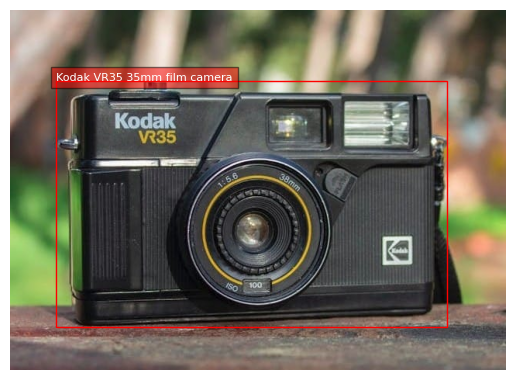

{'<DENSE_REGION_CAPTION>': {'bboxes': [[59.19999694824219, 91.37249755859375, 563.5199584960938, 408.50250244140625]], 'labels': ['Kodak VR35 35mm film camera']}}


In [ ]:
results = run_example(image, task_prompt = '<DENSE_REGION_CAPTION>')
draw_bbox(image, results['<DENSE_REGION_CAPTION>'])
print(results)

###<font color=40534C>**2.2 - Text Grounded Object Detection**</font>

<font color=40534C>Florence-2 can also perform text-grounded object detection. By providing specific object names or descriptions as input, Florence-2 detects bounding boxes around the specified objects</font>

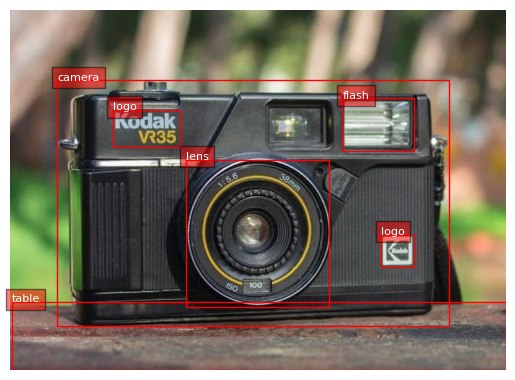

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[226.239990234375, 193.20750427246094, 410.55999755859375, 382.927490234375], [60.47999954223633, 90.90750122070312, 566.0800170898438, 408.0375061035156], [1.5999999046325684, 376.88250732421875, 639.0399780273438, 464.302490234375], [132.16000366210938, 129.03750610351562, 219.1999969482422, 177.3975067138672], [478.3999938964844, 289.927490234375, 521.2799682617188, 331.7774963378906], [428.47998046875, 114.15750122070312, 520.6400146484375, 181.58250427246094]], 'labels': ['lens', 'camera', 'table', 'logo', 'logo', 'flash']}}


In [ ]:
results = run_example(image,task_prompt= '<CAPTION_TO_PHRASE_GROUNDING>', text_input="lens. camera. table. logo. flash.")
draw_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])
print(results)

#<font color=40534C size="5.5">**3. Segmentation**</font>
###<font color=40534C>**3.1 - Text Grounded Segmentation**</font>

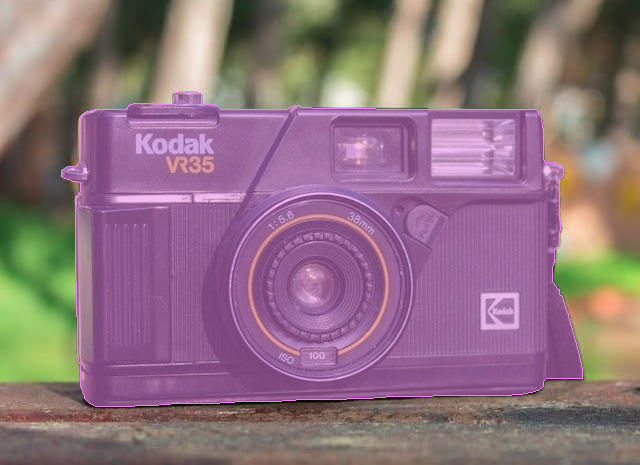

In [ ]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(image, task_prompt, text_input="camera")
output_image = copy.deepcopy(image)
draw_polygons(output_image, results[task_prompt])

###<font color=40534C>**3.2 - Region Grounded Segmentation**
<font color=40534C>As before, you can use the widget to manually draw a bounding box on the image. Once you're done, click 'Submit' to extract the coordinates. These bounding boxes will be used as the grounding for segmentation. Florence-2 will then generate a segmentation polygon for the selected region based on the bounding box.</font>


In [ ]:
widget = BBoxWidget()
widget.image = encode_image(img_path)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

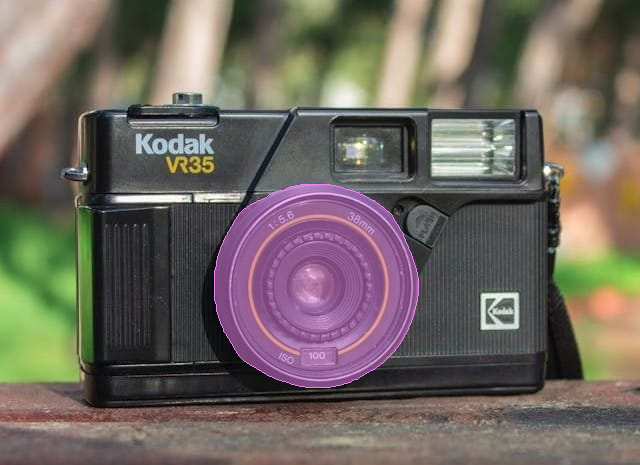

In [ ]:
box_str = convert_bbox_to_florence2(widget, img_path)

results = run_example(image,task_prompt= '<REGION_TO_SEGMENTATION>', text_input=box_str)
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'])

#<font color=40534C size="5.5">**4. Optical Character Recognition (OCR)**</font>
###<font color=40534C>**4.1 - Basic OCR**</font>
<font color=40534C>The first task extracts text from the entire image without identifying specific regions.</font>



In [ ]:
task_prompt = '<OCR>'
run_example(image,task_prompt)

{'<OCR>': 'KodakVR3538mm1:5.8100'}

###<font color=40534C>**4.2 - OCR with Regions**</font>

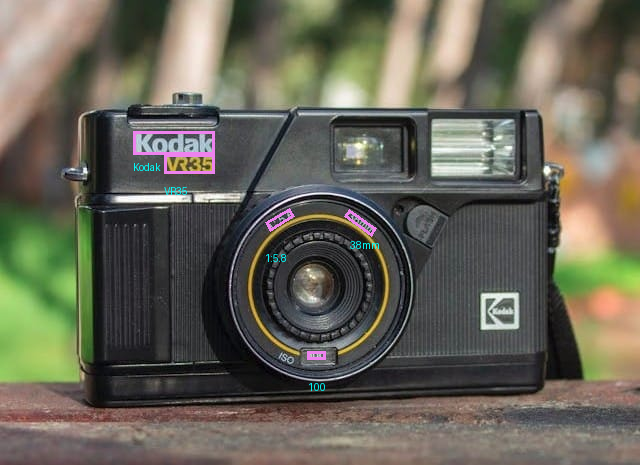

{'<OCR_WITH_REGION>': {'quad_boxes': [[133.44000244140625, 131.3625030517578, 214.72000122070312, 131.3625030517578, 214.72000122070312, 154.6125030517578, 133.44000244140625, 154.6125030517578], [164.16000366210938, 154.6125030517578, 214.72000122070312, 154.6125030517578, 214.72000122070312, 173.67750549316406, 164.16000366210938, 173.67750549316406], [265.2799987792969, 222.50250244140625, 289.6000061035156, 208.55250549316406, 294.7200012207031, 216.45750427246094, 270.3999938964844, 231.33750915527344], [349.7599792480469, 209.4824981689453, 376.6399841308594, 228.54750061035156, 371.5199890136719, 236.45249938964844, 344.6399841308594, 216.45750427246094], [307.5199890136719, 351.3074951171875, 325.44000244140625, 351.3074951171875, 325.44000244140625, 359.2124938964844, 307.5199890136719, 359.2124938964844]], 'labels': ['</s>Kodak', 'VR35', '1:5.8', '38mm', '100']}}


In [ ]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(image,task_prompt)
output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])
print(results)

# <font color=40534C size="6.5">**The End!**</font>
<font color=40534C>For more content from the author, please visit  [Here](https://medium.com/@lihigurarie)</font>

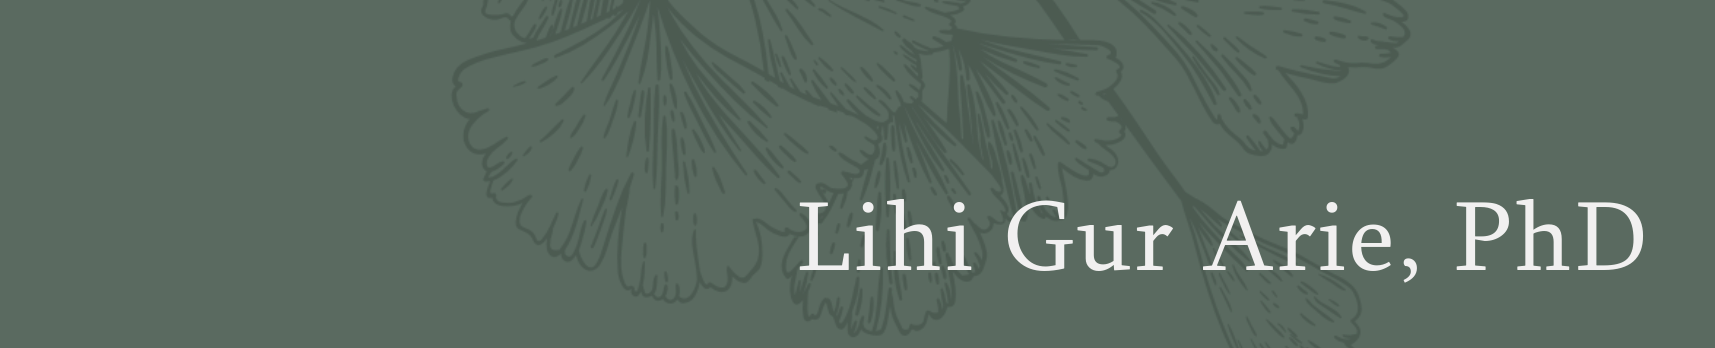